<a href="https://colab.research.google.com/github/xbabs/Customer-Buying-Behaviour-Prediction---British-Airways/blob/main/BA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Predictive modeling of customer bookings

This Colab notebook includes some code to get started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

In [1]:
# Imports google drive into this colab notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model development libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import itertools

In [3]:
# Reads in the customer booking data from google drive
# NOTE: for jupyter notebook, read in the data from your locasl computer
data = pd.read_csv("/content/drive/MyDrive/FORAGE - DATA SCIENCE EXPERIENCE/BA customer_booking.csv", encoding="ISO-8859-1")
data.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

## Data Cleaning and Preparation

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [5]:
data["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

data["flight_day"] = data["flight_day"].map(mapping)

In [7]:
data["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [8]:
data.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, I would explore the dataset with some visualisations and other useful metrics. Then, the dataset will be prepared for predictive modelling.

In [9]:
# Checking for null entries
data.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

## Exploratory data analysis

First, to explore the data in order to better understand it, statistical properties of the dataset will be explored including some visualization.

<ipython-input-10-d099b4ffd27b>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)


<Axes: title={'center': 'Shows the relationship between the features'}>

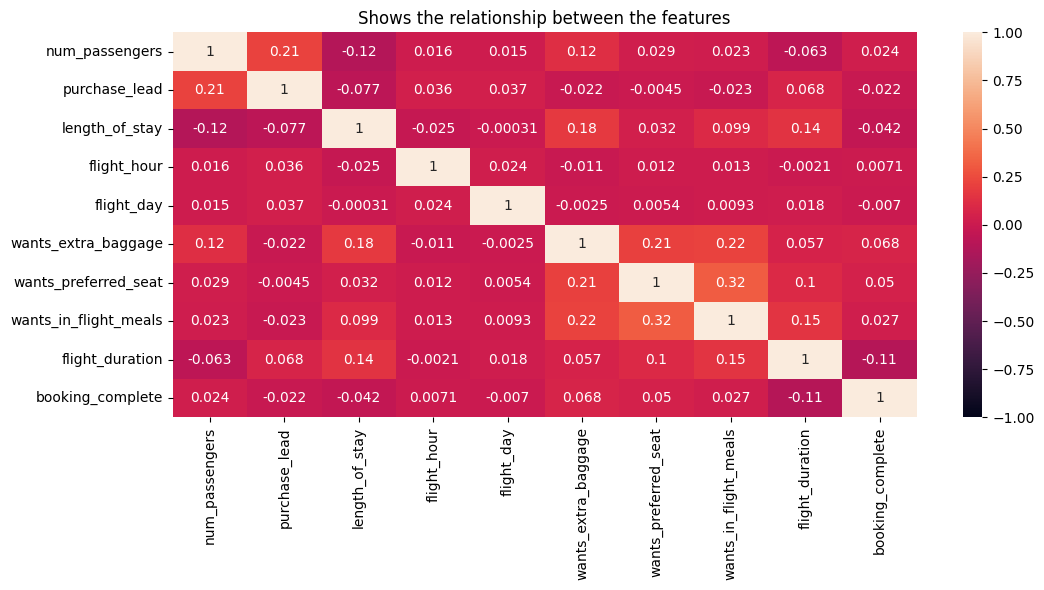

In [10]:
plt.figure(figsize=(12,5))
plt.title("Shows the relationship between the features")
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)

In [11]:
# numbers of complete and incomplete bookings
data.booking_complete.value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

In [12]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

In [13]:
X= data.drop('booking_complete',axis=1) # All features except the booking feature
y= data.booking_complete # complete booking feature

# changing object dtype to int dtype
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [14]:
def mutual_information(X, y):
    """
    Calculate mutual information scores between features.
    Returns:
    - An array of mutual information scores for each feature
    """
    mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

    return mi_scores
mi_scores = mutual_information(X, y)
mi_scores = pd.Series(mi_scores, name="Mutual Importance Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Print mutual information scores for each feature
for feature, score in zip(X.columns, mi_scores):
    print(f"{feature}: {score:.4f}")

num_passengers: 0.0545
sales_channel: 0.0455
trip_type: 0.0179
purchase_lead: 0.0108
length_of_stay: 0.0084
flight_hour: 0.0059
flight_day: 0.0038
route: 0.0035
booking_origin: 0.0034
wants_extra_baggage: 0.0032
wants_preferred_seat: 0.0009
wants_in_flight_meals: 0.0007
flight_duration: 0.0006


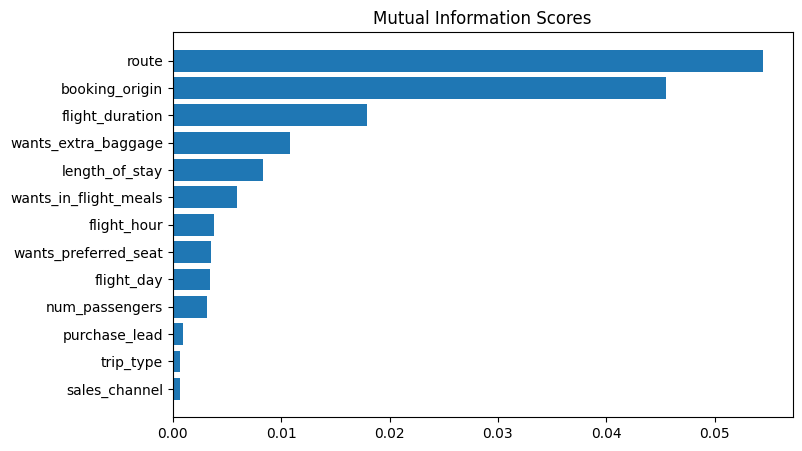

In [15]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [16]:
data.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [17]:
X = pd.get_dummies(X)

**MODEL TRAINING AND TESTING**

In [18]:
def build_models(X, y, test_size=0.25, random_state=42):
    """
    Build and evaluate multiple classification models.

    Parameters:
    - X: Feature matrix (numpy array or pandas DataFrame)
    - y: Target variable (numpy array or pandas Series)
    - test_size: Proportion of the data to use for testing (default is 0.25)
    - random_state: Random seed for reproducibility (default is 42)

    Returns:
    - A dictionary containing model names as keys and classification reports as values
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create a list of classification models to evaluate
    models = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Naive Bayes': GaussianNB()
    }

    # Create a dictionary to store classification reports
    classification_reports = {}

    for model_name, model in models.items():
        # Create a pipeline with a standard scaler (if needed) and the model
        if 'SVM' in model_name or 'K-Nearest Neighbors' in model_name:
            # Scale features for SVM and K-Nearest Neighbors
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                (model_name, model)
            ])
        else:
            # No scaling for other models
            pipeline = Pipeline([
                (model_name, model)
            ])

        # Train the model
        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test)

        # Evaluate the model using classification report
        report = classification_report(y_test, y_pred)
        classification_reports[model_name] = report

    return classification_reports

### Results: Evaluation metrics

In [19]:
if __name__ == "__main__":

    # Classification reports for all models
    classification_reports = build_models(X, y)

    # Print classification reports for each model
    for model_name, report in classification_reports.items():
        print(f"Model: {model_name}")
        print(report)
        print("=" * 60)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10648
           1       0.00      0.00      0.00      1852

    accuracy                           0.85     12500
   macro avg       0.43      0.50      0.46     12500
weighted avg       0.73      0.85      0.78     12500

Model: Decision Tree
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     10648
           1       0.29      0.33      0.31      1852

    accuracy                           0.78     12500
   macro avg       0.59      0.60      0.59     12500
weighted avg       0.79      0.78      0.79     12500

Model: Random Forest
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     10648
           1       0.56      0.11      0.19      1852

    accuracy                           0.86     12500
   macro avg       0.71      0.55      0.55     12500
weigh

### MODEL VALIDATION

In [20]:
def validate_models(X, y, test_size=0.2, random_state=42):

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create a list of classification models to validate
    models = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(probability=True),  # Enable probability estimates for ROC AUC
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Naive Bayes': GaussianNB()
    }

    # Create a DataFrame to store model names and their performance metrics
    metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

    for model_name, model in models.items():
        # Create a pipeline with a standard scaler (if needed) and the model
        if 'SVM' in model_name or 'K-Nearest Neighbors' in model_name:
            # Scale features for SVM and K-Nearest Neighbors
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                (model_name, model)
            ])
        else:
            # No scaling for other models
            pipeline = Pipeline([
                (model_name, model)
            ])

        # Train the model
        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test)

        # Calculate various metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

        # Add metrics to the DataFrame
        metrics_df = metrics_df.append({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC AUC': roc_auc}, ignore_index=True)

    return metrics_df

if __name__ == "__main__":

    # Validate and compare classification models
    model_metrics = validate_models(X, y)

    # Print the performance metrics for each model
    print(model_metrics)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-20-c62e1d212b21>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC AUC': roc_auc}, ignore_index=True)
<ipython-input-20-c62e1d212b21>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression    0.8519   0.000000  0.000000  0.000000  0.683058
1        Decision Tree    0.7774   0.283643  0.330405  0.305243  0.592608
2        Random Forest    0.8551   0.552189  0.110811  0.184581  0.773494
3                  SVM    0.8520   0.000000  0.000000  0.000000  0.631481
4  K-Nearest Neighbors    0.8324   0.314394  0.112162  0.165339  0.636645
5          Naive Bayes    0.8245   0.298091  0.137162  0.187876  0.665237


<ipython-input-20-c62e1d212b21>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC AUC': roc_auc}, ignore_index=True)
<ipython-input-20-c62e1d212b21>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC AUC': roc_auc}, ignore_index=True)


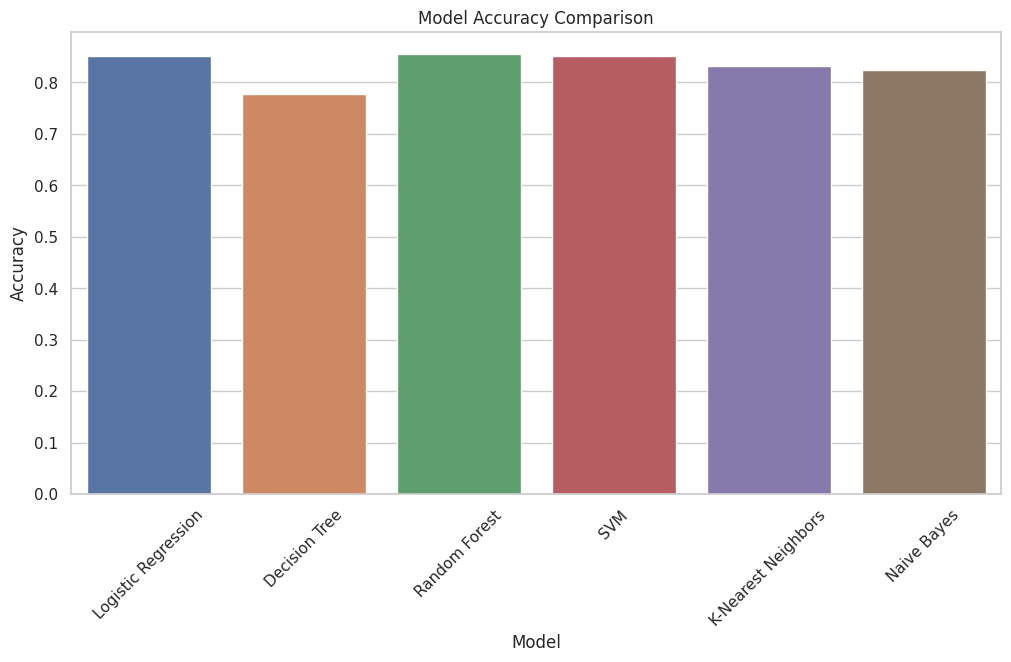

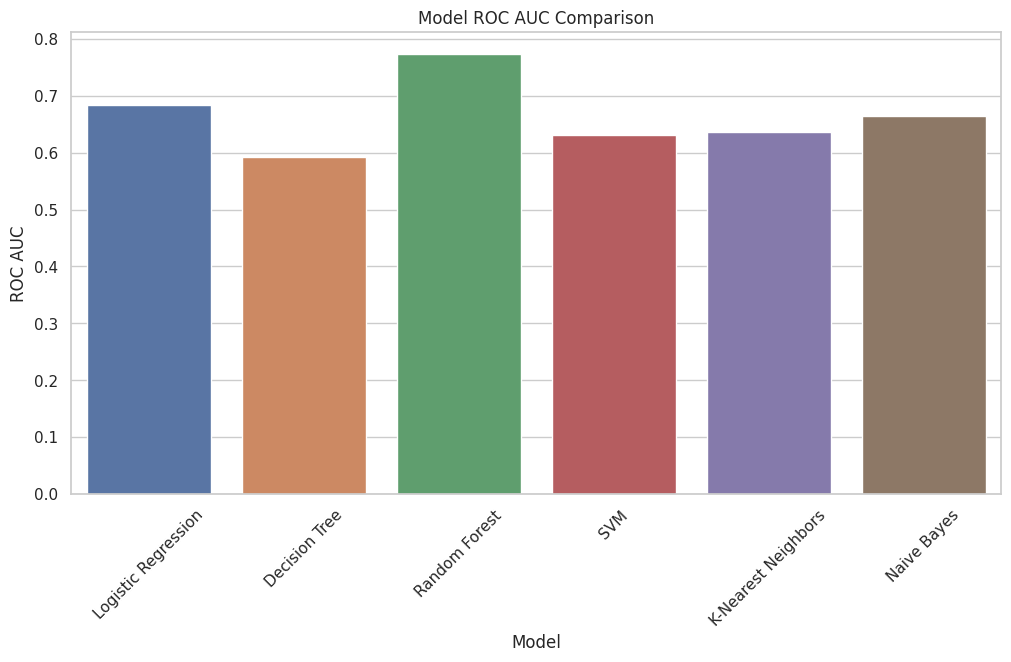

In [21]:
def visualize_results(model_metrics):
    """
    Visualize and interpret the results of the models.

    Parameters:
    - model_metrics: DataFrame containing model names and their performance metrics

    Returns:
    - None (displays visualizations and summary statistics)
    """
    # Set the style for plotting
    sns.set(style="whitegrid")

    # Plot performance metrics for each model
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x="Model", y="Accuracy", data=model_metrics)
    plt.title("Model Accuracy Comparison")
    plt.xticks(rotation=45)
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    plt.show()

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x="Model", y="ROC AUC", data=model_metrics)
    plt.title("Model ROC AUC Comparison")
    plt.xticks(rotation=45)
    plt.xlabel("Model")
    plt.ylabel("ROC AUC")
    plt.show()

if __name__ == "__main__":
    # Assuming you have a DataFrame called 'model_metrics' containing model names and metrics
    visualize_results(model_metrics)


### **FEATURE IMPORTANCE AND KEY FINDINGS**
Random forest model achieved the highest accuracy and precision of 85% and 57% respectively. This model will be used for posssible best prediction for a customer making a complete flight ticket booking. However, feature importance shows which exploratory features affects the prediction most

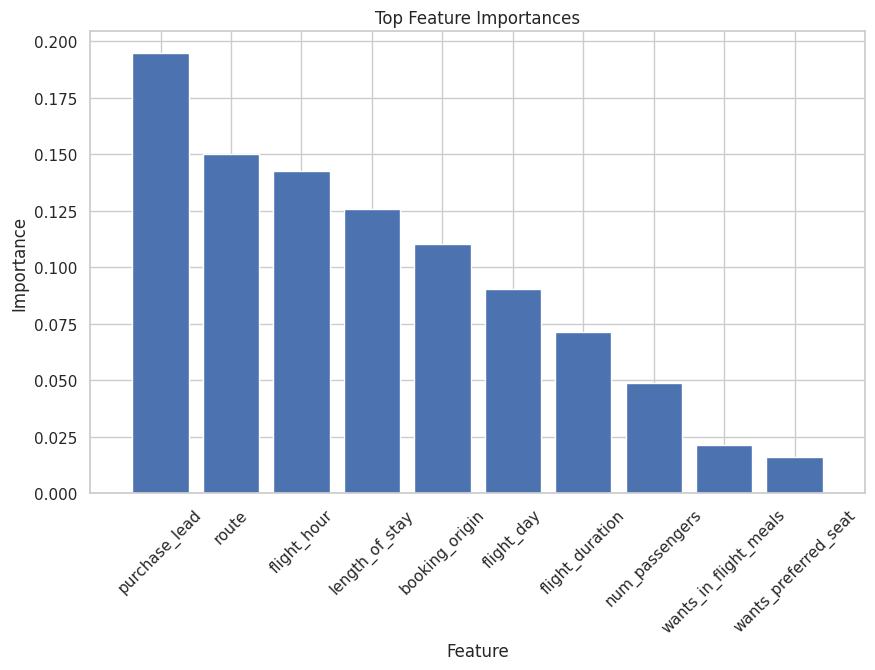

In [22]:
def plot_feature_importance(X, y, feature_names):
    # Create a Random Forest classifier
    clf = RandomForestClassifier(random_state=42)

    # Fit the model
    clf.fit(X, y)

    # Get feature importances
    importances = clf.feature_importances_

    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Plot the top N feature importances
    top_n = min(len(feature_names), 10)  # Plot at most the top 10 features
    plt.figure(figsize=(10, 6))
    plt.title("Top Feature Importances")
    plt.bar(range(top_n), importances[indices][:top_n], align="center")
    plt.xticks(range(top_n), [feature_names[i] for i in indices][:top_n], rotation=45)
    plt.xlim([-1, top_n])
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()

if __name__ == "__main__":
    feature_names = X.columns.tolist()

    # Plot feature importance
    plot_feature_importance(X, y, feature_names)


Although the mutual information describes the relationship between features, it emphasizes that ROUTE, BOOKING ORIGIN, WANTS EXTRA BAGGAGE and FLIGHT DURATION are the factors that best influences a customer completing a booking. Hence, the feature importance plot from the developed machine learning model identifies and analyses the factors that influences customer buying behaviour. These factors are PURCHASE LEAD, ROUTE, FLIGHT HOUR, LENGTH OF STAY, BOOKIING ORIGIN. Improving these factors will drive the customers to make bookings provided marketing options are more flexible to enhance customer's experience, thereby driving sales and generwating revenue.